<a href="https://colab.research.google.com/github/anjaleeDS/TrumpSpeak/blob/main/spacy_ner_trump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import spacy libs

!pip install -U spacy
!python -m spacy validate
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

# STOP AND RESTART RUNTIME

In [1]:
# basic Libraries
import pandas as pd
import os 
import regex as re
import string
import seaborn as sns
from matplotlib import pyplot as plt
import altair as alt

# ner Libraries
import spacy
import nltk
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
# print(string.punctuation)

# Fun settings to view results
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
# pd.describe_option('max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('/content/drive')
%cd drive/My\ Drive/Colab Notebooks/Sandbox/TrumpSpeeches

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Sandbox/TrumpSpeeches


In [3]:
%ls

BattleCreekDec19_2019.txt       MinneapolisOct10_2019.txt
BemidjiSep18_2020.txt           MosineeSep17_2020.txt
CharlestonFeb28_2020.txt        NewHampshireAug15_2019.txt
CharlotteMar2_2020.txt          NewHampshireAug28_2020.txt
CincinnatiAug1_2019.txt         NewHampshireFeb10_2020.txt
ColoradorSpringsFeb20_2020.txt  NewMexicoSep16_2019.txt
DallasOct17_2019.txt            OhioSep21_2020.txt
DesMoinesJan30_2020.txt         PhoenixFeb19_2020.txt
FayettevilleSep19_2020.txt      PittsburghSep22_2020.txt
FayettevilleSep9_2019.txt       spacy_ner_trump.ipynb
FreelandSep10_2020.txt          TexasSep23_2019.txt
GreenvilleJul17_2019.txt        ToledoJan9_2020.txt
HendersonSep13_2020.txt         trumpspeak.gsheet
HersheyDec10_2019.txt           TulsaJun20_2020.txt
LasVegasFeb21_2020.txt          TupeloNov1_2019.txt
LatrobeSep3_2020.txt            WildwoodJan28_2020.txt
LexingtonNov4_2019.txt          Winston-SalemSep8_2020.txt
MilwaukeeJan14_2020.txt         YumaAug18_2020.txt
MindenSep12_2020

# GET DATA FROM FILES


In [4]:

df = pd.DataFrame(columns=['name','text','nlp','r1', 'r2', 'r3', 'r4']) #throw in a few extra columns just in case
full_str=""

all_list = os.listdir() # grab the filenames
file_list = filter(lambda x: re.match('^[A-Z]',x), all_list) # only select the files that have capital letters
df.name = list(file_list)

for x in range(df.name.size):
  f = open(df.name[x], "rb")
  text_read = f.read().decode(errors='replace')
  text = str(text_read.lower())
  df.text[x] = text
  full_str += text
  f.close()

## First work with the combined speaches for common topics

In [5]:
# len(full_str), len(full_string), len(full_text)
# full_str.find('carolina') # found in position 8298
stopwordSet = set(stopwords.words("english"))

full_s = re.sub('[^a-zA-Z]'," ", full_str)
token_string = word_tokenize(full_s, language="english")

ft=""
for word in token_string:
  if(word) not in stopwordSet:
    ft += word + " "

In [9]:
len(ft)

1134428

## NER the entire text body for all locations



In [10]:
nlp_l = spacy.load('en_core_web_lg')
nlp_l.max_length = 1500000 #or whatever value > 1000000, as long as you don't run out of RAM

doc = nlp_l(ft)

In [12]:
list_text = []
list_ent = []

for ent in doc.ents:
    # print(ent.text, ent.start_char, ent.end_char, ent.label_)
    list_text.append(ent.text)
    list_ent.append(ent.label_)


entities = pd.DataFrame(columns=['text', 'ent'])
entities['text'] = list_text
entities['ent'] = list_ent

In [51]:
# vc_entities = pd.DataFrame(data=entities.value_counts(), columns=['text','ent','count'])

entities.ent.value_counts()
# len(entities.text)
# entities[entities.ent =='GPE'].value_counts()

GPE            4483
PERSON         3935
CARDINAL       2291
DATE           2216
NORP           2044
ORG            1357
ORDINAL         514
TIME            410
MONEY           220
LOC             188
QUANTITY         65
WORK_OF_ART      45
FAC              42
EVENT            35
PRODUCT          12
PERCENT           6
LAW               3
LANGUAGE          1
Name: ent, dtype: int64

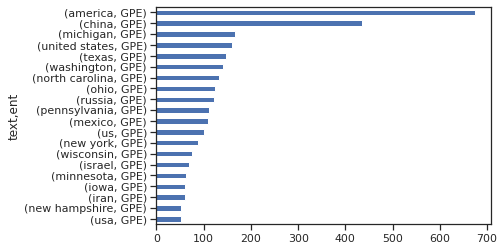

In [60]:
import seaborn as sns

entities[entities.ent =='GPE'].value_counts().head(20).sort_values().plot(kind = 'barh')
# entities.text.value_counts().head(15)

## break up by location and compare

In [ ]:
# GET DATA FROM FILES

df = pd.DataFrame(columns=['name','text','nlp','r1', 'r2', 'r3', 'r4']) #throw in a few extra columns just in case

all_list = os.listdir() # grab the filenames
file_list = filter(lambda x: re.match('^[A-Z]',x), all_list) # only select the files that have capital letters
df.name = list(file_list)
full_string = ""

for x in range(df.name.size):
  f = open(df.name[x], "rb")
  text_read = f.read().decode(errors='replace')
  text = str(text_read.lower())
  df.text[x] = text
  full_string += text
  f.close()

In [ ]:
# CLEAN UP TEXT WITH LEMMATIZATION
# 1. get english stopwords from nltk.corpus
# 2. instantiate lemmatizer

stopwordSet = set(stopwords.words("english"))
lemma = WordNetLemmatizer()
nlp_s = spacy.load('en_core_web_sm')
nlp_l = spacy.load('en_core_web_lg')
text_reviews = list()

for x in range(len(df.text)):
  text = re.sub('[^a-zA-Z]'," ", df.text[x])
  text = word_tokenize(text, language="english")
  text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet]
  text = " ".join(text)
  text_reviews.append(text)
  df.nlp[x] = text
  df.r1[x] = nlp_s(text)
  df.r2[x] = nlp_l(text)

# text_reviews

In [ ]:
df.head()

In [ ]:
# displacy.render(df.r1[0], style='ent', jupyter=True)
for s in range(len(df.r1)):
  matrix_s = list()

  for ent in df.r1[s].ents:
    matrix_s.append([ent.text,ent.label_])
  
  df.r3[s] = matrix_s

for s in range(len(df.r2)):
  matrix_l = list()

  for ent in df.r2[s].ents:
    matrix_l.append([ent.text,ent.label_])
  
  df.r4[s] = matrix_l


In [ ]:
df.r3

In [ ]:
list_ent = []
for speech in range(len(df.r1)):
  doc = df.r1[speech]
  # print(doc)
  for ent in range(len(doc.ents)):
  #   print(doc[ent].text, doc[ent].label_)
  #   list_text.append(ent.text)
  #   list_ent.append(ent.label_)


In [ ]:
for x in range(len(df.text)):
  for e in range(len(df.r2[x].ents)):
    print()

In [ ]:
# USE SPACY FOR NLP AND SAVE ENTITIES INTO SEPARATE DF

df.text[x] = text
nlp_s = spacy.load('en_core_web_sm')
df.nlp[x] = nlp(text)

nlp_l = spacy.load('en_core_web_lg')
doc = nlp(text)
# displacy.render(doc, style='ent', jupyter=True)


In [ ]:
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

In [ ]:
list_text = []
list_ent = []

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
    list_text.append(ent.text)
    list_ent.append(ent.label_)


NameError: ignored

In [ ]:
text_df = pd.DataFrame(list_text, columns=['text'])
text_df['ent'] = list_ent
text_df['cat'] = text_df.text+text_df.ent

text_df

,text,ent,cat
0,Bayes,ORG,BayesORG
1,the 1740s,DATE,the 1740sDATE
2,Thomas Bayes,PERSON,Thomas BayesPERSON
3,Bayes,ORG,BayesORG
4,the twentieth century,DATE,the twentieth centuryDATE
...,...,...,...
452,Bayesians,ORG,BayesiansORG
453,BUGS,ORG,BUGSORG
454,Bayesian,PERSON,BayesianPERSON
455,Bayes',ORG,Bayes'ORG


In [ ]:
!pip install squarify

[]

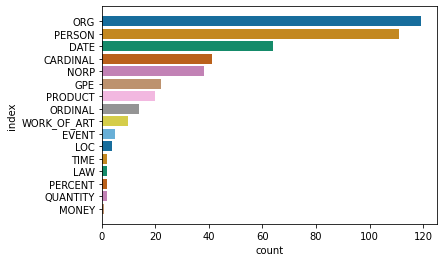

In [ ]:
#interested in the top N entities involved
def top_ents(entity, data_df, num):
  type_df = data_df[data_df.ent==entity]
  return(type_df.text.value_counts().head(num))

#what are the entities available?
devilpie = text_df.ent.value_counts()
devilpie = devilpie.to_frame(name='count').reset_index()

#let's just take the top 20
lilpie = devilpie[0:20]

#libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Reds")

ax = sns.barplot(data = lilpie, y='index', x='count',palette="colorblind")
# ax.set(xlabel="Entity Type")

plt.plot()

In [ ]:
#use the custom function and graph it!
temp = top_ents('ORG', text_df, 10)

#make into df for graphing
temp_df = temp.to_frame(name='count').reset_index()

bars = alt.Chart(temp_df).mark_bar().encode(
    x='count:Q',
    y=alt.Y('index:N', sort='x'),
    tooltip=('index:N', 'count:Q')
).interactive()

bars.properties(height=900)

alt.Chart(...)

In [ ]:
#graph it ALL
bars = alt.Chart(text_df).mark_bar().encode(
    x='count(ent):Q',
    y=alt.Y('text:N', sort='x'),
    tooltip=('ent:N', 'count(ent):Q')
).interactive()


text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='ent:Q'
)

bars.properties(height=900)